In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
df = pd.read_csv('dataset/amazon_alexa.tsv', delimiter='\t')
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


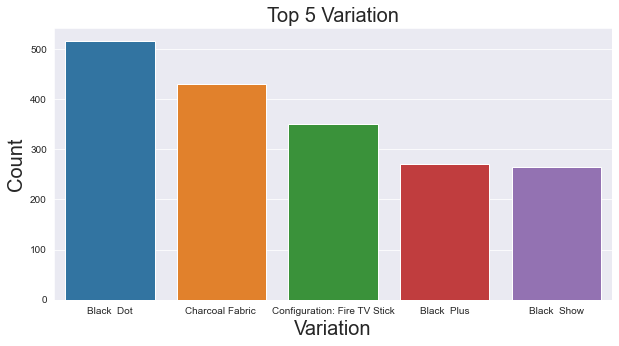

In [5]:
variation_label = df.variation.value_counts()[:5]
plt.figure(figsize=(10, 5))
sns.barplot(variation_label.index, variation_label);
plt.xlabel('Variation', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Top 5 Variation', fontsize=20);

In [6]:
df['len'] = df['verified_reviews'].map(len)
df.groupby('rating').describe()

feedback                                        len              \
          count mean  std  min  25%  50%  75%  max   count        mean   
rating                                                                   
1         161.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   161.0  195.000000   
2          96.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    96.0  249.187500   
3         152.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   152.0  207.296053   
4         455.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   455.0  178.520879   
5        2286.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  2286.0  108.444007   

                                                       
               std  min    25%    50%     75%     max  
rating                                                 
1       212.371226  1.0  36.00  120.0  284.00  1124.0  
2       269.595303  1.0  78.75  163.0  309.25  1686.0  
3       272.194706  1.0  54.00  130.0  284.00  1954.0  
4       215.927849  1.0  34.00   99.0  241.00  1360.0  
5       152.116387  1.0  26.00   64.0  135.00  2851.0

In [7]:
df.groupby('feedback').describe()

rating                                                  len  \
           count      mean       std  min  25%  50%  75%  max   count   
feedback                                                                
0          257.0  1.373541  0.484688  1.0  1.0  1.0  2.0  2.0   257.0   
1         2893.0  4.737643  0.546544  3.0  5.0  5.0  5.0  5.0  2893.0   

                                                                   
                mean         std  min   25%    50%    75%     max  
feedback                                                           
0         215.241245  236.325955  1.0  53.0  137.0  289.0  1686.0  
1         124.659177  174.624491  1.0  29.0   69.0  154.0  2851.0

5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64


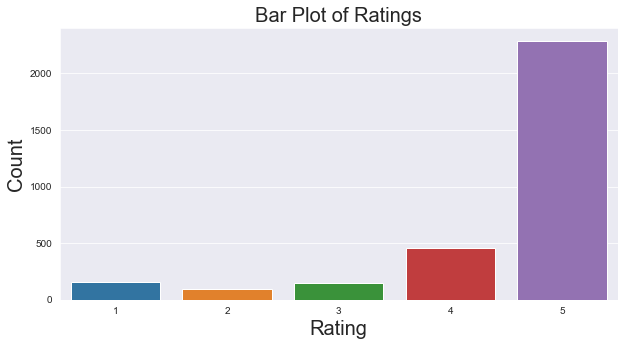

In [8]:
rating_label = df.rating.value_counts()
print(rating_label)
plt.figure(figsize=(10, 5))
sns.barplot(rating_label.index, rating_label);
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Count', fontsize=20);
plt.title('Bar Plot of Ratings', fontsize=20);

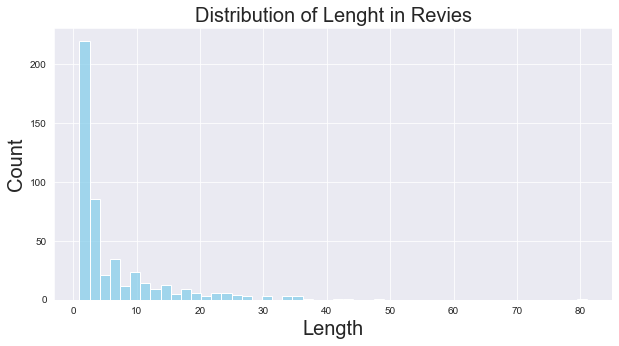

In [9]:
len_label = df['len'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(len_label, bins=50, color='skyblue');
plt.xlabel('Length', fontsize=20)
plt.ylabel('Count', fontsize=20);
plt.title('Distribution of Lenght in Revies', fontsize=20);

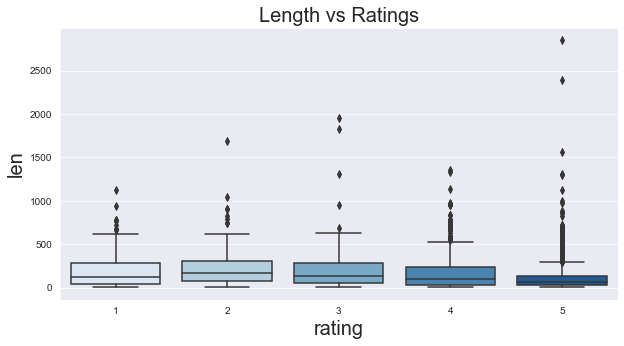

In [10]:
plt.figure(figsize=(10, 5))
sns.boxplot(df['rating'], df['len'], palette = 'Blues')
plt.title("Length vs Ratings", fontsize=20)
plt.xlabel('rating', fontsize=20)
plt.ylabel('len', fontsize=20);

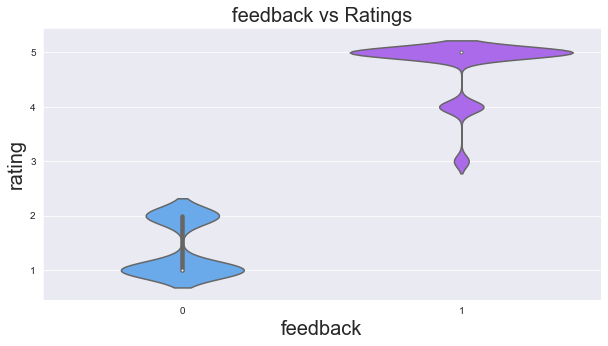

In [11]:
plt.figure(figsize=(10, 5))
sns.violinplot(df['feedback'], df['rating'], palette = 'cool')
plt.title("feedback vs Ratings", fontsize=20)
plt.xlabel('feedback', fontsize=20)
plt.ylabel('rating', fontsize=20);

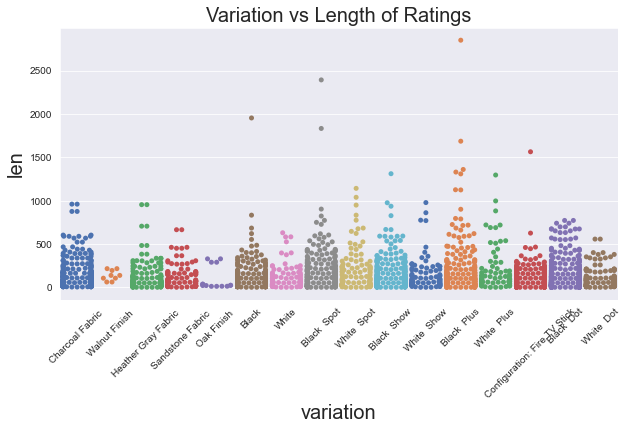

In [12]:
plt.figure(figsize=(10, 5))
sns.swarmplot(df['variation'], df['len'], palette = 'deep')
plt.title("Variation vs Length of Ratings", fontsize=20)
plt.xticks(rotation = 45);
plt.xlabel('variation', fontsize=20)
plt.ylabel('len', fontsize=20);

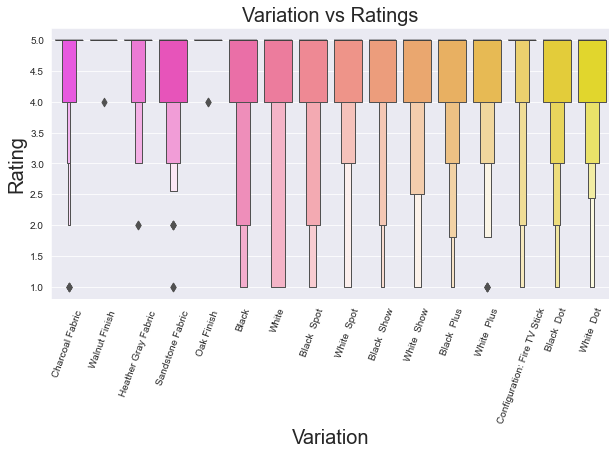

In [13]:
plt.figure(figsize=(10, 5))
sns.boxenplot(df['variation'], df['rating'], palette = 'spring')
plt.title("Variation vs Ratings", fontsize=20)
plt.xticks(rotation = 70);
plt.xlabel('Variation', fontsize=20)
plt.ylabel('Rating', fontsize=20);

In [14]:
count_vector = CountVectorizer(stop_words='english') 
ws = count_vector.fit_transform(df.verified_reviews)
s_w = ws.sum(axis=0)
w_f = [(w, s_w[0, idx]) for w, idx in count_vector.vocabulary_.items()]
w_f = sorted(w_f, key = lambda x: x[1], reverse = True)
freq = pd.DataFrame(w_f, columns=['word', 'freq'])

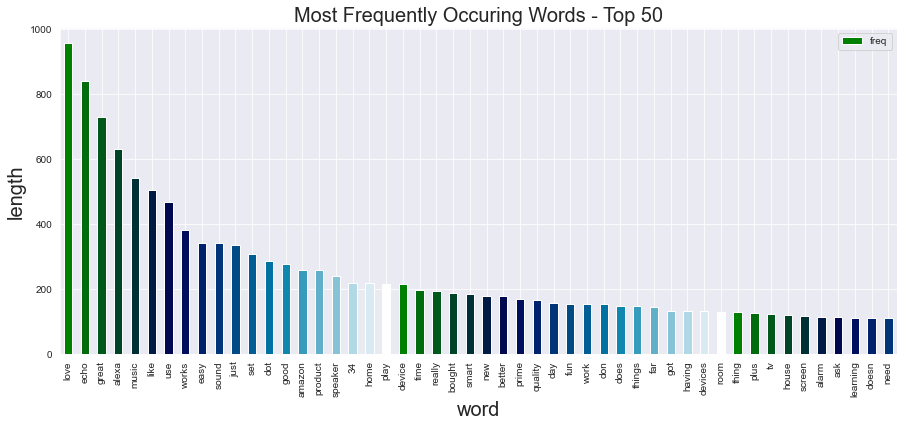

In [15]:
color = plt.cm.ocean(np.linspace(0, 1, 20))
freq.head(50).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 50", fontsize=20)
plt.xlabel('word', fontsize=20)
plt.ylabel('length', fontsize=20);

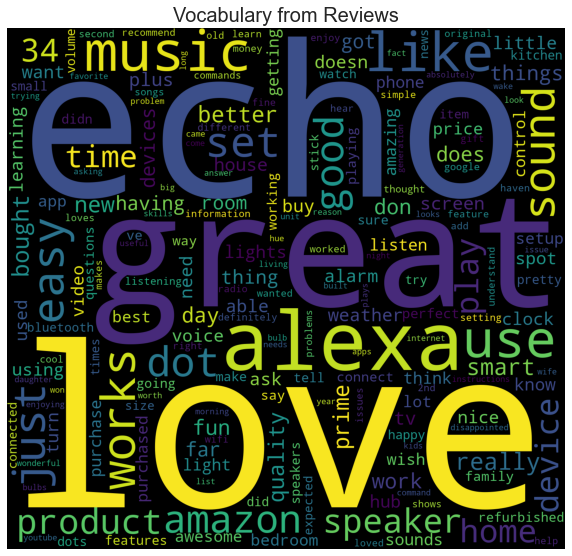

In [16]:
word_cloud = WordCloud(background_color='black', width=1500, height=1400).generate_from_frequencies(dict(w_f))
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(word_cloud)
plt.title("Vocabulary from Reviews", fontsize = 20);

In [17]:
c = []
for i in range(0, 3150):
    r = re.sub('[^a-zA-Z]', ' ', df['verified_reviews'][i])
    r = r.lower()
    r = r.split()
    ps = PorterStemmer()
    sw = stopwords.words('english')
    sw.remove('not')
    r = [ps.stem(word) for word in r if not word in set(sw)]
    r = ' '.join(r)
    c.append(r)

In [18]:
count_vector = CountVectorizer(max_features=2500) 
X = count_vector.fit_transform(c).toarray()
y = df.iloc[:, 4].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [19]:
min_max_sc = MinMaxScaler()
X_train = min_max_sc.fit_transform(X_train)
X_test = min_max_sc.transform(X_test)

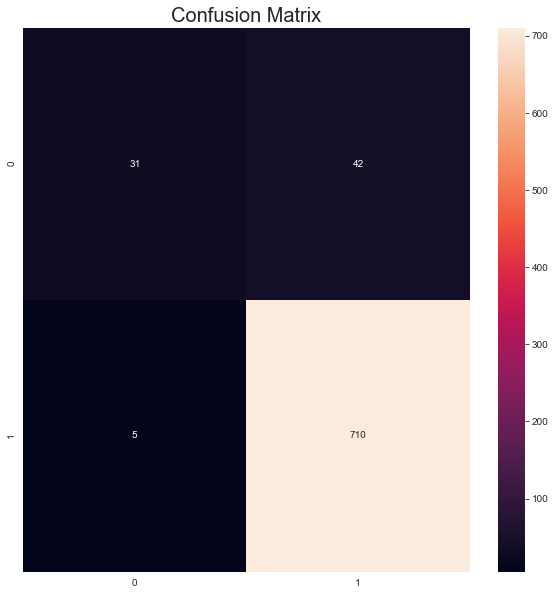

In [20]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g');
plt.title('Confusion Matrix', fontsize=20);

In [21]:
p = {'bootstrap': [True],'max_depth': [80, 100],'min_samples_split': [8, 12],'n_estimators': [100, 300]}
grid_cv = GridSearchCV(estimator=rf, param_grid=p, cv=10, verbose=0, scoring='accuracy', n_jobs=-1, 
                       return_train_score=True)
grid_cv.fit(X_train, y_train.ravel())

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True, scoring='accuracy')

In [22]:
rf_cv = RandomForestClassifier(bootstrap=True, max_depth=80, min_samples_split=8, n_estimators=300)
rf_cv.fit(X_train, y_train)
pred = rf_cv.predict(X_test)

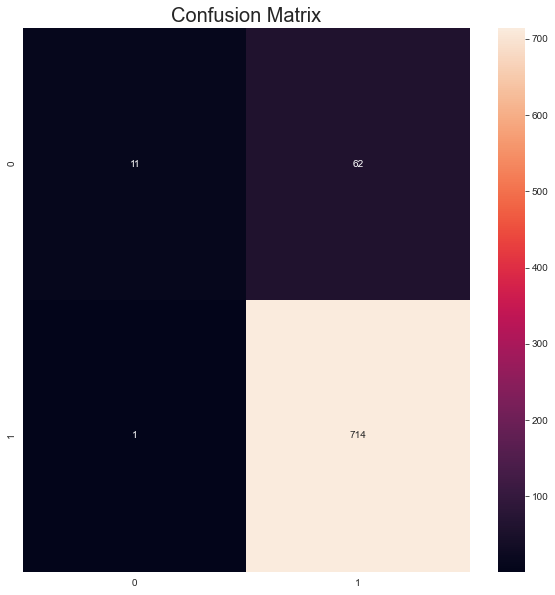

In [23]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='g');
plt.title('Confusion Matrix', fontsize=20);